# Step 1: EDA & Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import gmplot
import time
import re
import string


pd.set_option("max_colwidth", 500)
import warnings
warnings.filterwarnings('ignore')


from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("data/Corona_NLP_train.csv")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
#data cleaning
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df['Month'] = df['TweetAt'].dt.month.map({1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
df.drop_duplicates(subset = ['OriginalTweet'], inplace = True)

### Only select English tweets

In [5]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [6]:
#only selects 'English' tweets
df = df[df.OriginalTweet.apply(isEnglish)]
df.shape

(34095, 7)

In [7]:
df.Month.value_counts().sort_values(ascending = False)
#more than half of the tweets are in March

Mar    21618
Apr     2096
Aug     1588
Jul     1554
Jun     1441
Sep     1250
May      915
Oct      855
Feb      813
Nov      764
Dec      680
Jan      521
Name: Month, dtype: int64

In [8]:
#only select 'Mar' 'English' tweets
#'TweetAt' min: 01-04-2020; max:2020-12-04
df = df[df.Month == 'Mar']
df.shape

(21618, 7)

### Overall location distribution for our tweets

In [9]:
# have a look at where's all the tweets from - get 500 random sample from our 5000 data points as this step is pretty slow. 
geolocator = Nominatim(user_agent = "geoapiExercises")

# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for count, user_loc in enumerate(df.sample(500).Location):
    try:
        location = geolocator.geocode(user_loc)
        
        # If coordinates are found for location
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            
    # If too many connection requests
    except:
        pass
    
# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("visualization/Tweets Heatmap_March2020.html")

# Step 2: Text Preprocessing
### Standardizing Text

In [10]:
def standardize_text(tweet):
    # Replace punctuations with a white space (TF-IDF will also remove)
    clean_text = re.sub('[%s]'% re.escape(string.punctuation), '', tweet) 
    
    clean_text = re.sub("http\S+", "", clean_text)
    clean_text = re.sub("http", "", clean_text)
    clean_text = re.sub("@\S+", "", clean_text)
    clean_text = re.sub("@", "at", clean_text)
    clean_text = re.sub("\r", "", clean_text)
    clean_text = re.sub("\n", "", clean_text)
    
    clean_text = re.sub('\w*\d\w*', ' ', clean_text)  #remove numbers
    clean_text = clean_text.lower()  #lower all letters
    
    return clean_text

In [11]:
df['Cleaned_Tweet'] = df['OriginalTweet'].apply(standardize_text)
df_clean = df[['Location', 'Month', 'OriginalTweet','TweetAt', 'Cleaned_Tweet']]

### TF-IDF: Tokenization

In [12]:
corpus = df_clean['Cleaned_Tweet']

In [13]:
#set stop words
stop_words = ENGLISH_STOP_WORDS.union(['covid', '19', 'covid19', 'coronavirus', 'covid_19'])
vectorizer = TfidfVectorizer(stop_words=stop_words) #(stop_words = 'english')

tweet_word_matrix = vectorizer.fit_transform(corpus) #document-term sparse matrix
print(tweet_word_matrix.shape) 

vocab = vectorizer.get_feature_names()  #list of all the unique values/words
# pd.DataFrame(tweet_word_matrix.toarray(), index=corpus, columns=vocab)  #don't do dataframe for larger dataset

(21618, 38618)


# Step 3: NMF Topic Modeling on whole dataset

### Tweet-Topic Matrix(10 components)

In [14]:
nmf_10 = NMF(n_components=10)  #top 10 topic
tweet_topic_matrix = nmf_10.fit_transform(tweet_word_matrix) 

tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix, columns = ["topic_1","topic_2", "topic_3","topic_4", 
                      "topic_5","topic_6","topic_7","topic_8","topic_9", "topic_10"])

tweet_topic_matrix_df[['Raw_Tweet', 'Clean_Tweet', 'TweetAt']] = df_clean.reset_index()[['OriginalTweet', 'Cleaned_Tweet','TweetAt']]
tweet_topic_matrix_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,Raw_Tweet,Clean_Tweet,TweetAt
0,0.000002,0.000000,0.000000,0.000081,0.000000,0.000087,0.000000,0.0,0.000000,0.000000,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,menyrbie philgahan chrisitv and and,2020-03-16
1,0.002648,0.000000,0.049493,0.002147,0.000000,0.000898,0.001565,0.0,0.001369,0.003270,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order,2020-03-16
2,0.001725,0.004775,0.057554,0.010528,0.000031,0.005841,0.000000,0.0,0.007905,0.000961,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid outbreak,2020-03-16
3,0.061358,0.000000,0.002953,0.000000,0.000000,0.000000,0.007972,0.0,0.000000,0.003832,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",my food stock is not the only one which is emptyplease dont panic there will be enough food for everyone if you do not take more than you need stay calm stay coronavirus confinement confinementotal confinementgeneral,2020-03-16
4,0.032083,0.000000,0.000000,0.000000,0.000000,0.028705,0.000204,0.0,0.000000,0.000000,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",me ready to go at supermarket during the outbreaknot because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortagecoronavirusfrance restezchezvous stayathome confinement,2020-03-16


### Have a look at top 6 words for 10 topics to understand the topics

In [15]:
def get_top_topic_words(nmf):
    topic_words = [] # list of lists, one for each topic

    ### find the top 6 word weights for each topic component,
    ### using terms to create a corresponding list of the top 8 words. 
    ### Add each list to topic_words 
    for topic in nmf.components_:  # for each components
        top_terms = topic.argsort()[-6:]  #argsort: only asending order. top 8 words index for later to locate #a array
        topic_words.append([vocab[top_term] for top_term in top_terms])  #use position to get word out from terms
                                                                         #list of list

    return topic_words

In [16]:
get_top_topic_words(nmf_10)

[['people', 'stock', 'need', 'buying', 'panic', 'food'],
 ['people', 'going', 'stores', 'retail', 'grocery', 'store'],
 ['stay', 'amazon', 'delivery', 'home', 'online', 'shopping'],
 ['amid', 'low', 'price', 'gas', 'oil', 'prices'],
 ['toiletpaperpanic', 'rolls', 'roll', 'toiletpaper', 'paper', 'toilet'],
 ['just', 'like', 'local', 'shelves', 'people', 'supermarket'],
 ['use', 'masks', 'hands', 'make', 'hand', 'sanitizer'],
 ['delivery', 'employees', 'staff', 'drivers', 'thank', 'workers'],
 ['scams', 'business', 'behavior', 'impact', 'pandemic', 'consumer'],
 ['support', 'social', 'stay', 'help', 'home', 'amp']]

**Conclusion:**
* Topic1: Panic buying & stocking food
* Topic2: Grocery & retail
* Topic3: Online shopping & delivery
* Topic4: Gas price decline
* Topic5: Toilet paper hoarding 
* Topic6: Supermarket shelves are empty - Food shortage 
* Topic7: Mask & Hand sanitizer shortage
* Topic8: Thanks ALL front-line workers
* Topic9: Covid impact on business & economy
* Topic10: StayAtHome

### Word-Topic Matrix(10 components)

In [17]:
words_topic_df = pd.DataFrame(nmf_10.components_.round(5),
             index = ["topic_1","topic_2", "topic_3","topic_4", 
                      "topic_5","topic_6","topic_7","topic_8", "topic_9", "topic_10"],
             columns = vectorizer.get_feature_names()).T 

### Topic Interpretation(10 components)

In [18]:
def topic_check(topic_name, n = 6):
    print(words_topic_df.sort_values(by=topic_name, ascending=False)[topic_name].head(6))  #topic: "panic buying & stocking food"
    print('\n')
    print(tweet_topic_matrix_df.sort_values(by=topic_name, ascending=False)['Raw_Tweet'].head(n))

In [19]:
topic_check('topic_1')  #topic: "panic buying & stocking food"

food      3.10440
panic     2.22928
buying    1.64429
need      0.84418
stock     0.79783
people    0.72580
Name: topic_1, dtype: float64


9651                                                                                                                    #Covid_19 stop panic buying theres enough food etc for everyone https://t.co/FfABnl3Upo
9283                                                                                               all this #coronavirus we need to stop panic buying so the old and the people that are still working get food
15452                                                                                                                        Minister The country has enough food supplies there is no need for panic buying 19
1881     #Coronavirus seriously can people stop buying free from food cause they have already hoarded the other food. People need the free from food due to medical issue. Please stop panic buy there is need.
5816                        

In [20]:
topic_check('topic_4') #gas price decline

prices    2.18250
oil       0.86757
gas       0.55974
price     0.34268
low       0.31083
amid      0.25001
Name: topic_4, dtype: float64


3352                                                   Oil prices at $23.18\r\r\n#Oilprices #coronavirus
3353                                Oil prices at $22.90\r\r\n#Oilprices #coronavirus #CoronaVirusUpdate
4021                         Oil prices at 2002 already, are we back almost 20 years due to #coronavirus
19424                                                                    I do like Covid 19 gas prices  
6280     Toilet paper prices went up while gas prices going down. #covid_19\r\r\nhttps://t.co/jp5aYlra9R
3954                       Gas prices keep going down because of COVID-19. \r\r\nhttps://t.co/GCX7Mz3M21
Name: Raw_Tweet, dtype: object


# STEP 4: Geolocating for 5000 random sample data (take sample as this step is extremely slow)

In [21]:
df_sample = df_clean.sample(5000, random_state = 101)[['Location', 'Month', 'OriginalTweet','TweetAt', 'Cleaned_Tweet']]
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 21541 to 24828
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Location       3975 non-null   object        
 1   Month          5000 non-null   object        
 2   OriginalTweet  5000 non-null   object        
 3   TweetAt        5000 non-null   datetime64[ns]
 4   Cleaned_Tweet  5000 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 234.4+ KB


In [22]:
df_sample.head()

,Location,Month,OriginalTweet,TweetAt,Cleaned_Tweet
21541,NaN,Mar,"Supermarket #purchaselimits mean people have to shop more often to get basics like milk, each time with possible exposure to the #coronavirus \r\r\nSupermarkets your well-meaning restrictions will end up killing people.\r\r\n\r\r\n#StayHome #StayHomeStaySafe",2020-03-25,supermarket purchaselimits mean people have to shop more often to get basics like milk each time with possible exposure to the coronavirus supermarkets your wellmeaning restrictions will end up killing peoplestayhome stayhomestaysafe
14111,"New Brunswick, Canada",Mar,"People want to hope #coronavirus comes with a 6 month case of diarrhea, else they are going to need to build an addition to store all their toiletpaper. Shelves empty at SuperStore again today.",2020-03-21,people want to hope coronavirus comes with a month case of diarrhea else they are going to need to build an addition to store all their toiletpaper shelves empty at superstore again today
17114,"Chapel Hill, NC, USA",Mar,MEDIA ADVISORY A panel convened by amp the Kenan Institute will be offering a press briefing on the dramatic short and long term impact of the 19 financial downturn on personal amp consumer finance Join Tues March 24 at 11 a m,2020-03-23,media advisory a panel convened by amp the kenan institute will be offering a press briefing on the dramatic short and long term impact of the financial downturn on personal amp consumer finance join tues march at a m
23595,Virginia,Mar,New Jersey Man Charged with Terroristic Threats for Deliberately Coughing on Grocery Store Worker And Stating He Had Covid 19 Faces a 7 year prison sentence via,2020-03-26,new jersey man charged with terroristic threats for deliberately coughing on grocery store worker and stating he had covid faces a year prison sentence via
2167,NaN,Mar,A COVID-19 Cure for Restaurants: Reaching Older Diners : https://t.co/kZaVPbZ53w #foodservices,2020-03-17,a cure for restaurants reaching older diners foodservices


### (1)Extract Country information from messy Location column.

In [23]:
def country_convert(loc):
    try:
        geolocator = Nominatim(user_agent = "geoapiExercises")
        location = geolocator.geocode(loc)
        return location.address.split(',')[-1].lstrip()
    except AttributeError:
        # print("Unrecognizable: ", loc)
        # time.sleep(5)
        return 'N/A'    
    except:
        pass

In [24]:
df_sample['Country'] = df_sample['Location'].apply(country_convert)

In [25]:
#check point to avoid lossing the 'Country' we just get via Geolocator
df_sample.to_csv('data/March_English_Clean.csv')

In [26]:
df_sample_clean = pd.read_csv('data/March_English_Clean.csv', index_col = 0)
df_sample_clean.head()

,Location,Month,OriginalTweet,Country,Cleaned_Tweet,TweetAt
21541,NaN,Mar,"Supermarket #purchaselimits mean people have to shop more often to get basics like milk, each time with possible exposure to the #coronavirus \r\r\nSupermarkets your well-meaning restrictions will end up killing people.\r\r\n\r\r\n#StayHome #StayHomeStaySafe",Italia,supermarket purchaselimits mean people have to shop more often to get basics like milk each time with possible exposure to the coronavirus supermarkets your wellmeaning restrictions will end up killing peoplestayhome stayhomestaysafe,2020-03-25
14111,"New Brunswick, Canada",Mar,"People want to hope #coronavirus comes with a 6 month case of diarrhea, else they are going to need to build an addition to store all their toiletpaper. Shelves empty at SuperStore again today.",Canada,people want to hope coronavirus comes with a month case of diarrhea else they are going to need to build an addition to store all their toiletpaper shelves empty at superstore again today,2020-03-21
17114,"Chapel Hill, NC, USA",Mar,MEDIA ADVISORY A panel convened by amp the Kenan Institute will be offering a press briefing on the dramatic short and long term impact of the 19 financial downturn on personal amp consumer finance Join Tues March 24 at 11 a m,United States,media advisory a panel convened by amp the kenan institute will be offering a press briefing on the dramatic short and long term impact of the financial downturn on personal amp consumer finance join tues march at a m,2020-03-23
23595,Virginia,Mar,New Jersey Man Charged with Terroristic Threats for Deliberately Coughing on Grocery Store Worker And Stating He Had Covid 19 Faces a 7 year prison sentence via,United States,new jersey man charged with terroristic threats for deliberately coughing on grocery store worker and stating he had covid faces a year prison sentence via,2020-03-26
2167,NaN,Mar,A COVID-19 Cure for Restaurants: Reaching Older Diners : https://t.co/kZaVPbZ53w #foodservices,Italia,a cure for restaurants reaching older diners foodservices,2020-03-17


In [27]:
df_sample_clean.Country.value_counts().sort_values(ascending=False) 
#top three United States, Italia, United Kingdom

United States     1494
Italia            1043
United Kingdom     720
Canada             239
India              191
                  ... 
ليبيا                1
Қазақстан            1
Eesti                1
Isle of Man          1
Tchad تشاد           1
Name: Country, Length: 107, dtype: int64

In [28]:
# sample result should be the same with above entire data result.
corpus = df_sample_clean['Cleaned_Tweet']

#set stop words
stop_words = ENGLISH_STOP_WORDS.union(['covid', '19', 'covid19', 'coronavirus', 'covid_19'])
vectorizer = TfidfVectorizer(stop_words=stop_words) #(or stop_words = 'english' by default)

tweet_word_matrix = vectorizer.fit_transform(corpus) #document-term sparse matrix
print(tweet_word_matrix.shape) #15422 unique words
vocab = vectorizer.get_feature_names()  #list of all the unique values/words
# pd.DataFrame(tweet_word_matrix.toarray(), index=corpus, columns=vocab)  #no dataframe for larger dataset

nmf_10 = NMF(n_components=10)  #top 10 topic
tweet_topic_matrix = nmf_10.fit_transform(tweet_word_matrix) 
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix, columns = ["topic_1","topic_2", "topic_3","topic_4", 
                      "topic_5","topic_6","topic_7","topic_8", "topic_9", "topic_10"])
tweet_topic_matrix_df[['Raw_Tweet', 'Clean_Tweet', 'TweetAt','Country']] = df_sample_clean.reset_index()[['OriginalTweet', 'Cleaned_Tweet','TweetAt','Country']]
print(tweet_topic_matrix_df.shape)
get_top_topic_words(nmf_10)
#It is sample result with our entire data result

(5000, 15422)
(5000, 14)


[['stop', 'need', 'stock', 'buying', 'panic', 'food'],
 ['going', 'stores', 'retail', 'employees', 'grocery', 'store'],
 ['stay', 'amazon', 'home', 'delivery', 'shopping', 'online'],
 ['don', 'pandemic', 'roll', 'toiletpaper', 'paper', 'toilet'],
 ['amid', 'low', 'price', 'gas', 'oil', 'prices'],
 ['just', 'like', 'staff', 'local', 'shelves', 'supermarket'],
 ['use', 'hands', 'soap', 'make', 'hand', 'sanitizer'],
 ['staff', 'delivery', 'drivers', 'thank', 'workers', 'amp'],
 ['economy', 'behavior', 'business', 'impact', 'pandemic', 'consumer'],
 ['time', 'stop', 'stay', 'safe', 'need', 'people']]

### (2) Visualization 
### scattertext : comparison between USA & Italia

In [29]:
import scattertext as st

In [30]:
corpus = st.CorpusFromPandas(tweet_topic_matrix_df[(tweet_topic_matrix_df['Country']== 'United States') | (tweet_topic_matrix_df['Country']== 'Italia')], #dataframe
                             category_col='Country',  #distinct category
                             text_col='Clean_Tweet',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [31]:
html = st.produce_scattertext_explorer(
        corpus,
        category='United States',
        category_name='United States',
        not_category_name='Italia',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000
        )

In [32]:
open('visualization/comparison USA vs.Italia-March_2020.html', 'wb').write(html.encode('utf-8'));

### Important words comparision from Scattertext: 
* USA: 'tolietpaper'(71 vs. 36 per 1000 tweets), 'gas'(29 vs. 10), 'scams'(21 vs. 6)...
* Italia: 'panic'(39 vs. 99), 'lockdown'(9 vs. 30), 'hoarding'(10 vs.20)...
* Sharing words: 'jobs', 'testing'...

### Visualize comparison for 3 country with most tweets - USA & Italia & UK

In [33]:
mask = (tweet_topic_matrix_df.Country == 'United States') | (tweet_topic_matrix_df.Country == 'Italia') |(tweet_topic_matrix_df.Country == 'United Kingdom')
new_df = tweet_topic_matrix_df[mask]
new_df.Country.value_counts()

United States     1494
Italia            1043
United Kingdom     720
Name: Country, dtype: int64

In [34]:
#group by country, then flatten dataframe
data = new_df[["topic_1","topic_2", "topic_3","topic_4","topic_5","topic_6","topic_7","topic_8", "topic_9", "topic_10","Country"]].groupby(['Country']).mean().unstack().reset_index()
data.columns = ['Topics', 'Country', 'Average_Topic_Score']
data.head()

,Topics,Country,Average_Topic_Score
0,topic_1,Italia,0.010639
1,topic_1,United Kingdom,0.011291
2,topic_1,United States,0.007335
3,topic_2,Italia,0.016632
4,topic_2,United Kingdom,0.003747


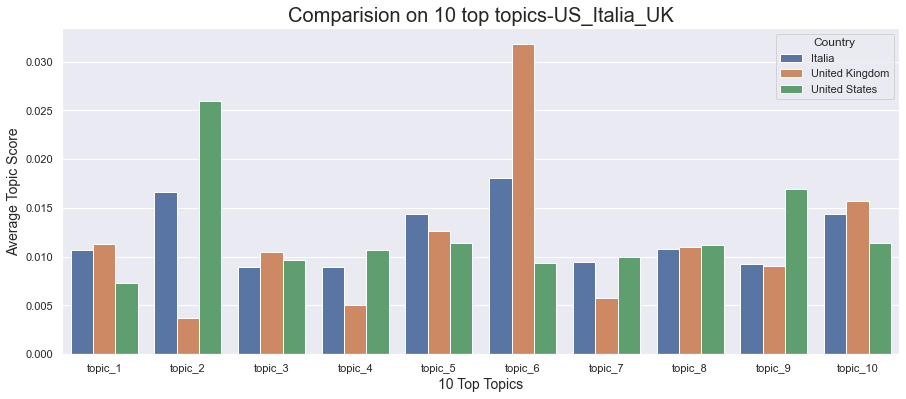

In [35]:
plt.figure(figsize = [15,6])
sns.barplot(x=data.Topics, y=data['Average_Topic_Score'], data=data, hue = data.Country)
plt.title("Comparision on 10 top topics-US_Italia_UK", fontsize = 20)
plt.xlabel("10 Top Topics", fontsize = 14)
plt.ylabel("Average Topic Score", fontsize = 14)
plt.savefig('visualization/Bar Chart on 10 topics Comparision-US_Italia_UK.png')

### (3)Top 10 topic for each country('United States', 'Italia', 'United Kingkom')

In [36]:
def country_topic_modeling(country):
    corpus = df_sample_clean[df_sample_clean.Country == country]['Cleaned_Tweet']

    #set stop words
    stop_words = ENGLISH_STOP_WORDS.union(['covid', '19', 'covid19', 'coronavirus', 'covid_19'])
    vectorizer = TfidfVectorizer(stop_words=stop_words) 

    tweet_word_matrix = vectorizer.fit_transform(corpus) #document term sparse matrix
    print(tweet_word_matrix.shape) 
    vocab = vectorizer.get_feature_names()  #list of all the unique values/words
    # pd.DataFrame(tweet_word_matrix.toarray(), index=corpus, columns=vocab)  #no dataframe for larger dataset

    nmf_10 = NMF(n_components=10)  #top 10 topic
    tweet_topic_matrix = nmf_10.fit_transform(tweet_word_matrix) 
    tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix, columns = ["topic_1","topic_2", "topic_3","topic_4", 
                          "topic_5","topic_6","topic_7","topic_8", "topic_9", "topic_10"])
    tweet_topic_matrix_df[['Raw_Tweet', 'Clean_Tweet', 'TweetAt']] = df_sample_clean[df_sample_clean.Country == country].reset_index()[['OriginalTweet', 'Cleaned_Tweet','TweetAt']]
    print(tweet_topic_matrix_df.shape)
    
    topic_words = [] # list of lists, one for each topic

    for topic in nmf_10.components_:  # for each components
        top_terms = topic.argsort()[-6:]  #argsort: only asending order. top 6 words index for later to locate #a array
        topic_words.append([vocab[top_term] for top_term in top_terms])  #use position to get word out from terms
                                                                         #list of list

    return topic_words

### United States top 10 topic 

In [37]:
country_topic_modeling('United States')

(1494, 6715)
(1494, 13)


[['going', 'stores', 'retail', 'people', 'grocery', 'store'],
 ['bank', 'need', 'supply', 'panic', 'demand', 'food'],
 ['toiletpapercrisis', 'people', 'pandemic', 'toiletpaper', 'toilet', 'paper'],
 ['tips', 'businesses', 'home', 'stay', 'online', 'shopping'],
 ['oil', 'like', 'cents', 'price', 'gas', 'prices'],
 ['laundry', 'spray', 'hands', 'make', 'hand', 'sanitizer'],
 ['spending', 'behavior', 'reports', 'business', 'amp', 'consumer'],
 ['kroger', 'chain', 'paid', 'leave', 'sick', 'supermarket'],
 ['fears', 'advantage', 'help', 'tips', 'scams', 'scammers'],
 ['working', 'nurses', 'people', 'employees', 'thank', 'workers']]

### Italia top 10 topic

In [38]:
country_topic_modeling('Italia')

(1043, 5492)
(1043, 13)


[['help', 'food', 'home', 'stock', 'stay', 'need'],
 ['stores', 'worker', 'retail', 'going', 'grocery', 'store'],
 ['toiletpapercrisis', 'run', 'don', 'toiletpaper', 'paper', 'toilet'],
 ['day', 'lockdown', 'rules', 'new', 'online', 'shopping'],
 ['demand', 'report', 'shops', 'pandemic', 'oil', 'prices'],
 ['working', 'lockdown', 'shop', 'shelves', 'local', 'supermarket'],
 ['youre', 'crazy', 'think', 'time', 'safe', 'people'],
 ['masks', 'use', 'soap', 'hands', 'hand', 'sanitizer'],
 ['panicbuying', 'buyers', 'shelves', 'food', 'buying', 'panic'],
 ['employees', 'delivery', 'drivers', 'thank', 'workers', 'amp']]

### United Kingdom top 10 topic

In [39]:
country_topic_modeling('United Kingdom')

(720, 4099)
(720, 13)


[['opening', 'hours', 'nhs', 'staff', 'workers', 'supermarket'],
 ['stoppanicbuying', 'buy', 'stop', 'buying', 'panic', 'food'],
 ['companies', 'pandemic', 'hiking', 'report', 'shops', 'prices'],
 ['just', 'delivery', 'order', 'slots', 'online', 'shopping'],
 ['need', 'shelves', 'think', 'supermarket', 'stop', 'people'],
 ['roll', 'bread', 'like', 'supermarket', 'toilet', 'local'],
 ['dont', 'work', 'safe', 'time', 'stay', 'home'],
 ['aldiuk', 'lidlgb', 'morrisons', 'sainsburys', 'asda', 'tesco'],
 ['closed', 'social', 'hand', 'store', 'sanitizer', 'amp'],
 ['service', 'read', 'contracts', 'outbreak', 'uk', 'consumer']]

# Step 7: Clustering - Kmeans

In [40]:
X = tweet_topic_matrix_df[["topic_1","topic_2", "topic_3","topic_4", 
                      "topic_5","topic_6","topic_7","topic_8", "topic_9", "topic_10"]] #10 dimension 

In [41]:
# Elbow method & silhouettes to pick K
inertias = []
silhouettes = []
clusters = range(2,15)

for num_clusters in clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels = km.labels_))

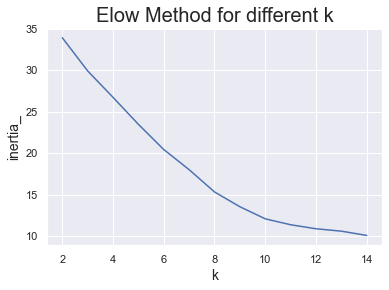

In [42]:
fig,ax = plt.subplots()
ax.plot(clusters,inertias)  # 10 cluster? 6 cluster? 
plt.title("Elow Method for different k", fontsize = 20)
plt.xlabel("k", fontsize = 14)
plt.ylabel('inertia_', fontsize = 14)
plt.savefig('visualization/Elbow_Method_for_clustering.png')

In [43]:
silhouettes #range(2,15) 

[0.24080239392031863,
 0.21520531648798163,
 0.23523769186749333,
 0.2536077580191261,
 0.27706005662944333,
 0.3069303809198805,
 0.32750672265686426,
 0.33901643861806685,
 0.3542065394950113,
 0.33322448877961586,
 0.32889302105113855,
 0.3246210714858453,
 0.3192720938147825]

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.24080239392031863
For n_clusters = 4 The average silhouette_score is : 0.24517348898025604
For n_clusters = 6 The average silhouette_score is : 0.2918675095032771
For n_clusters = 8 The average silhouette_score is : 0.32746901219328695
For n_clusters = 10 The average silhouette_score is : 0.3541161402451348


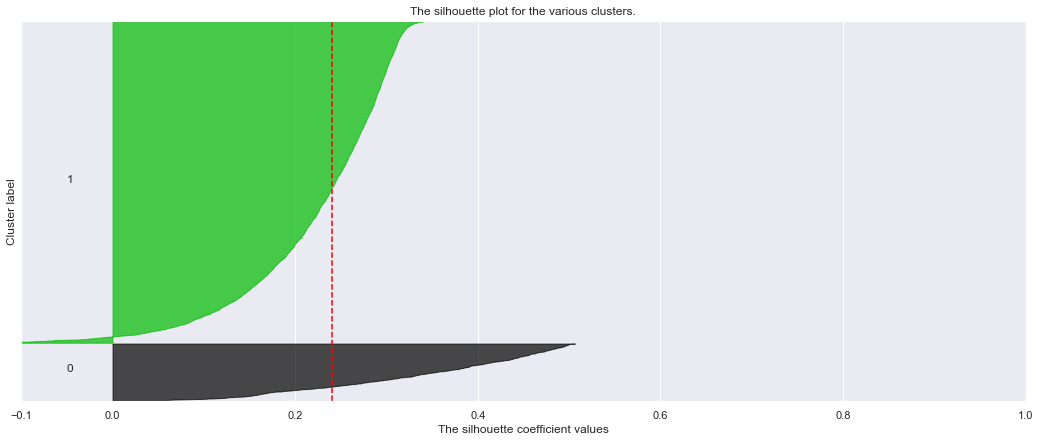

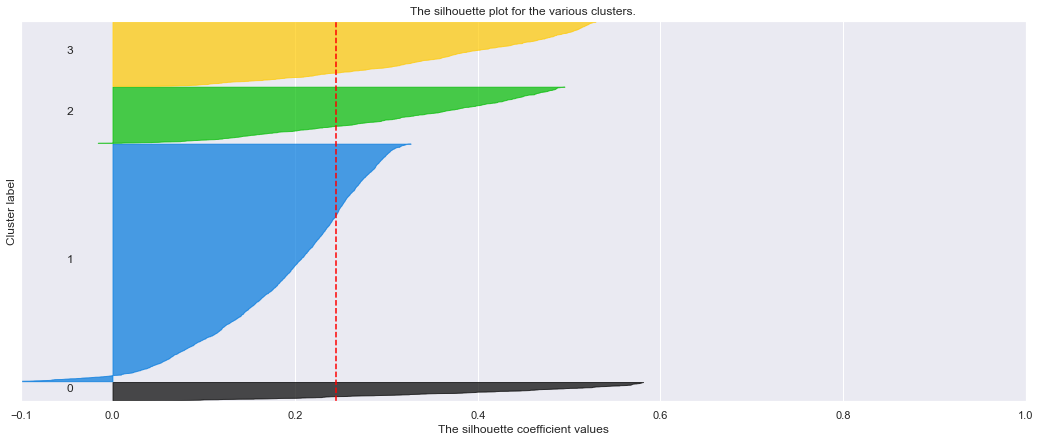

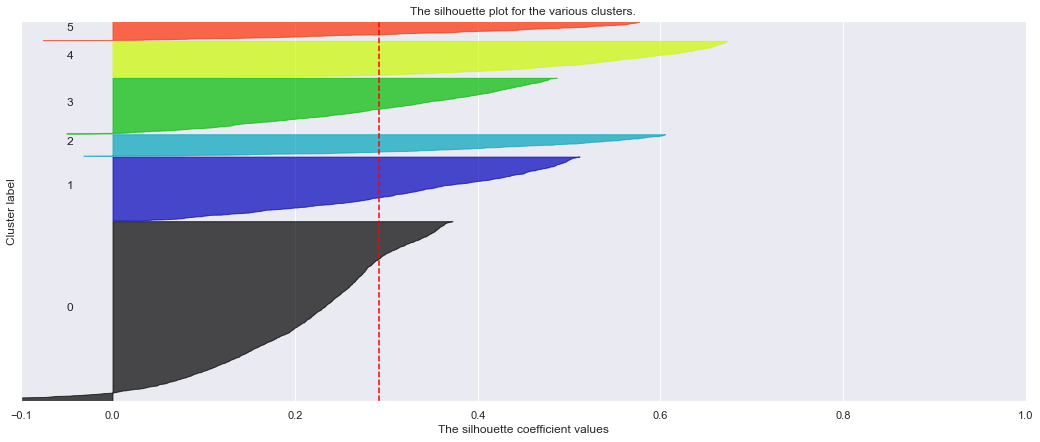

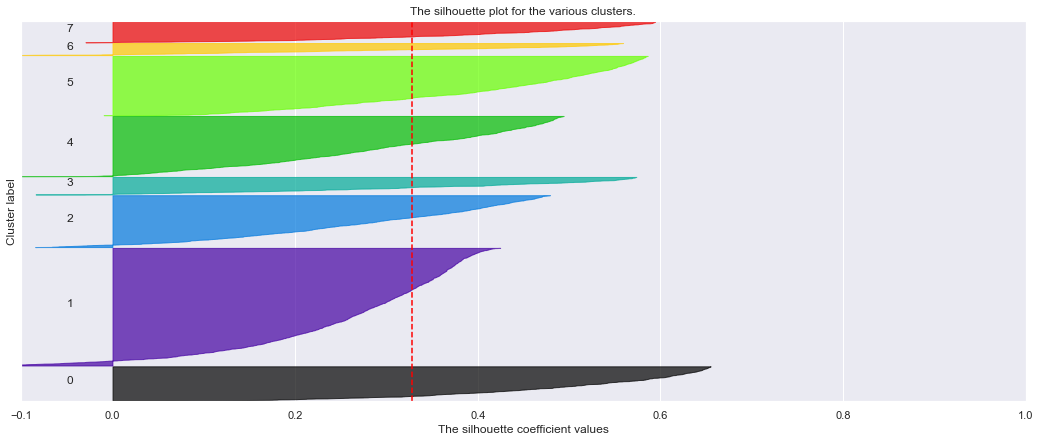

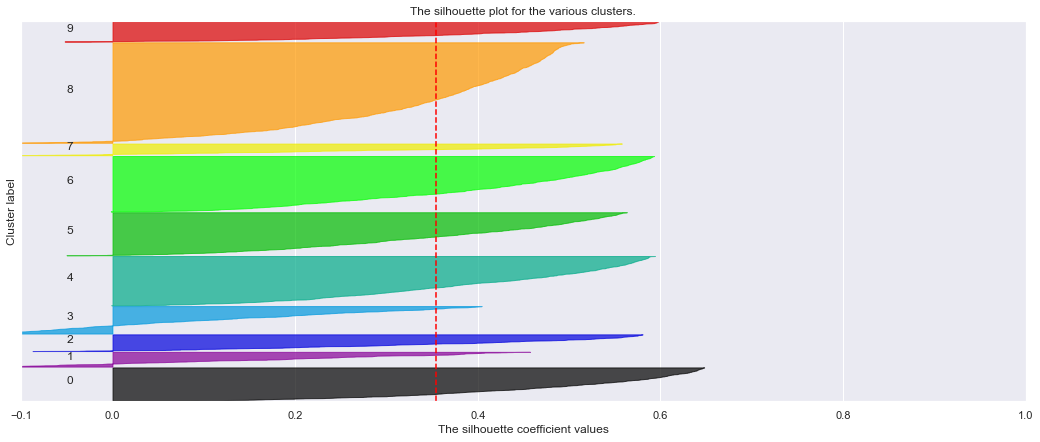

<Figure size 432x288 with 0 Axes>

In [44]:
#Selecting the number of clusters with silhouette analysis on KMeans clustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm

print(__doc__)


range_n_clusters = [2, 4, 6, 8, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
plt.show()
plt.savefig('visualization/silhouette analysis on KMeans clustering.png')

### KMeans(6 clusters)

In [45]:
# training model
X = tweet_topic_matrix_df[["topic_1","topic_2", "topic_3","topic_4", 
                      "topic_5","topic_6", "topic_7", "topic_8", "topic_9", "topic_10"]] #10 dimension 
km = KMeans(n_clusters=6)
km.fit(X)
pred_classes = km.predict(X)  #prediction

In [46]:
#adding group labels to each tweets
tweet_topic_matrix_df['Cluster_label'] = pred_classes
tweet_topic_matrix_df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,Raw_Tweet,Clean_Tweet,TweetAt,Country,Cluster_label
0,0.000000,0.000000,0.003183,0.000000,0.005079,0.074459,0.000000,0.000000,0.000000,0.081390,"Supermarket #purchaselimits mean people have to shop more often to get basics like milk, each time with possible exposure to the #coronavirus \r\r\nSupermarkets your well-meaning restrictions will end up killing people.\r\r\n\r\r\n#StayHome #StayHomeStaySafe",supermarket purchaselimits mean people have to shop more often to get basics like milk each time with possible exposure to the coronavirus supermarkets your wellmeaning restrictions will end up killing peoplestayhome stayhomestaysafe,2020-03-25,Italia,5
1,0.004982,0.046613,0.000000,0.038355,0.000000,0.027463,0.000000,0.000000,0.000000,0.091338,"People want to hope #coronavirus comes with a 6 month case of diarrhea, else they are going to need to build an addition to store all their toiletpaper. Shelves empty at SuperStore again today.",people want to hope coronavirus comes with a month case of diarrhea else they are going to need to build an addition to store all their toiletpaper shelves empty at superstore again today,2020-03-21,Canada,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070067,0.081848,0.000000,MEDIA ADVISORY A panel convened by amp the Kenan Institute will be offering a press briefing on the dramatic short and long term impact of the 19 financial downturn on personal amp consumer finance Join Tues March 24 at 11 a m,media advisory a panel convened by amp the kenan institute will be offering a press briefing on the dramatic short and long term impact of the financial downturn on personal amp consumer finance join tues march at a m,2020-03-23,United States,3
3,0.000000,0.080335,0.001536,0.000218,0.001808,0.002330,0.000000,0.000000,0.003821,0.000000,New Jersey Man Charged with Terroristic Threats for Deliberately Coughing on Grocery Store Worker And Stating He Had Covid 19 Faces a 7 year prison sentence via,new jersey man charged with terroristic threats for deliberately coughing on grocery store worker and stating he had covid faces a year prison sentence via,2020-03-26,United States,0
4,0.000610,0.002638,0.002892,0.000201,0.000000,0.004577,0.000000,0.000845,0.001365,0.003110,A COVID-19 Cure for Restaurants: Reaching Older Diners : https://t.co/kZaVPbZ53w #foodservices,a cure for restaurants reaching older diners foodservices,2020-03-17,Italia,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.004523,0.001029,0.000000,0.006035,0.000000,0.001941,0.000672,0.000425,0.011077,0.012193,"Ummmmmmmmmm, how bout, shit you need?! The jeanyuses at @CNN providing rock-solid information, as always. Ay Dios mio! ? #FakeNews #coronavirus \r\r\nhttps://t.co/X22lyFwgAI",ummmmmmmmmm how bout shit you need the jeanyuses at cnn providing rocksolid information as always ay dios mio fakenews coronavirus,2020-03-17,United States,3
4996,0.000000,0.034130,0.118662,0.000000,0.000000,0.000074,0.000000,0.000000,0.000000,0.000000,"Happy Spring! ? Our online store is now open!\r\r\n\r\r\nThe retail shop is now closed due to COVID-19. Front-door, daily pick-up of online orders will be from 11am-2pm. \r\r\n\r\r\nOrder online at https://t.co/IYcVRHj8JX for shipping or next day pick-up. \r\r\n\r\r\nP.S. Hopped Pear is back! ? #cider https://t.co/JAuBoajf4V",happy spring our online store is now openthe retail shop is now closed due to frontdoor daily pickup of online orders will be from order online at for shipping or next day pickup ps hopped pear is back cider,2020-03-21,Canada,2
4997,0.000000,0.070720,0.000784,0.002910,0.000000,0.014767,0.000000,0.000000,0.004190,0.058156,Let's not forget that people only post the negative on social media in terms of Corovnavirus hysteria.\r\r\n\r\r\nNo one is going to say they went to the grocery store and everything went seamless. \r\r\n\r\r\nThis does not get attention and the sole reason 

### Interperate clusters: each cluster are with a combination of different topics.
### Only return the top 3 topics for each cluster

In [47]:
my_topics = ["topic_1","topic_2", "topic_3","topic_4", "topic_5",
             "topic_6","topic_7","topic_8", "topic_9", "topic_10"]
for i in range(6):
    top_topics = []
    for t in my_topics:
        top_topics.append((np.sum(tweet_topic_matrix_df[tweet_topic_matrix_df['Cluster_label']==i][t]),t))
    top_topics.sort(reverse = True)  #inplace
    print(f"Cluster {i} : {top_topics[:3]}")

Cluster 0 : [(64.3751220759105, 'topic_2'), (15.363191824189656, 'topic_8'), (11.147006688819417, 'topic_10')]
Cluster 1 : [(24.827479491956435, 'topic_4'), (2.745864987453087, 'topic_10'), (2.640498239385219, 'topic_2')]
Cluster 2 : [(31.61870717815342, 'topic_3'), (3.760100331269909, 'topic_10'), (2.4983375320074384, 'topic_8')]
Cluster 3 : [(64.83739430875468, 'topic_5'), (54.42857445726706, 'topic_9'), (32.91785243720484, 'topic_1')]
Cluster 4 : [(29.584803259131796, 'topic_7'), (2.182071744214248, 'topic_8'), (2.0860851064409784, 'topic_5')]
Cluster 5 : [(62.645223985230444, 'topic_6'), (14.732298844021845, 'topic_10'), (12.685392373037176, 'topic_8')]


### Interpertation 
Each cluster are with documents with **overlaped topic**, it's also explained why there was negative value for my silhouette analysis plot from earlier

### Next Step: Ingesting new data via Twitter API then compare the current top topics/discussion with March_2020
Please see the second notebook for more details